### 문장 벡터를 벡터화 시키는 방법

1. word embedding
    - 문장을 신경망에 학습시키고, 
2. one-hot-encoding (방식과 비슷함)
    - 단어 하나하나를 index 에 mapping


# IMDB 자료 분석

In [1]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
# 동일한 결과를 재현하기 위해서 random seed 고정
import numpy as np
np.random.seed(777)

In [3]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (waning)

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

## 1. 데이터 준비

In [4]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [5]:
# 위에 블럭 실행되면 이거는 실행 안시켜도됨. 위에꺼 에러떴을때 이거 쓸것

from tensorflow.keras.datasets import imdb
import numpy as np

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

In [30]:
sample_idx = 5
print(train_data[sample_idx]) # 인덱스 값을 4로 두고, 가장 빈번하게 사용된 항만 출력해보기.

# 이 인덱스값을 1이던 뭐던 바꿔도 첫 인덱스는 항상 1로 시작한다.

[1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 7982, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]


In [31]:
print(train_labels[sample_idx])

0


In [8]:
word_index = imdb.get_word_index() # 특정 단어를 하나의 정수 인덱스로 매핑해놓은 딕셔너리
reverse_word_index = dict([(v,k) for (k, v) in word_index.items()]) # {단어: 정수} => {정수: 단어}로 저장 

# 벡터화 된 문장을 텍스트로 디코딩
# 0, 1, 2번째 단어는 '패딩', '문서 시작', '사전에 없음'을 뜻하는 기호임
decoded_review = ' '.join([reverse_word_index.get(i-3,'?') for i in train_data[sample_idx]])
print(decoded_review)

? worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the ? and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life


## 2. 데이터 전처리

In [9]:
import numpy as np

'''
텍스트를 벡터 처리 할 때,
padding (여백) 부분을 제외한 실제 유의미한 단어만 처리가 된다.
(설명이 틀리면 나중에 다시 고칠 예정)

len(sequences) 를 뽑아보면 load_data=10000 으로 했으니 10000개로 딱 떨어지는게 아니라
문자에 특수문자 3개가 포함해서 대략 그 숫자까지 포함된 10003개 정도로 나온다.
'''

# 문자형을 벡터로 바꿔줌
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # 결과를 저장할 0 행렬 생성
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1 # 문장에 존재하는 단어들만 one-hot encoding
    return results

# 문장들을 일정한 크기의 벡터로 변환
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

In [10]:
# 리스트 형태인 레이블을 벡터로 변환
y_train = np.array(train_labels).astype('float32')
y_test = np.array(test_labels).astype('float32')

In [11]:
print(X_train[0]) # 각 문장의 index

[0. 1. 1. ... 0. 0. 0.]


In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000, 10000)
(25000,)
(25000, 10000)
(25000,)


In [13]:
'''
사실 이 부분이 그렇게 좋은 문법은 아니다.
valid와 train 을 10000개 기점으로 짤라버리고 나머지는 본인이 가지는 형식인데,
이 셀을 만약에 중복해서 쓰다보면,
valid 에 25000개가 있었다가 10000개를 뗴줬는데, 또 실행하게 되면
valid 에 15000개가 있었다가 10000개를 떼주면 5000개가 남음
slicing 을 해줄때는 변수명을 다르게 써주는게 좀 안정적이긴 하다.
'''

X_valid = X_train[:10000]
X_train = X_train[10000:]
y_valid = y_train[:10000]
y_train = y_train[10000:]

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(15000, 10000)
(15000,)
(10000, 10000)
(10000,)
(25000, 10000)
(25000,)


## 3. 네트워크 정의

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

'''
항상 여기 부분을 할 땐 input layer 와 output layer 출력에 유의해야한다.

어떤건 렐루쓰고 어떤건 시그모이드를 쓰는 이유는?
각 레이어마다 역할이 다르다.
우선 입력과 히든에 비선형을 쓰는 이유는, 선형회귀로만 할 수 있는것이 정해져있다.
입력에 따라서 값이 일정한 것이 선형함수인데,
그래서 선형함수로 써서 공간변형을 하는건 형이 정해져있다.
정해진 형이 아닌 다른 형으로 바꾸고 싶을때 비선형을 이용한다.
히든 레이어 : 비선형적인 연산을 수행하기 위함 (렐루함수가 꺾여있으니까)
보통 회귀할땐 마지막부분에 시그모이드 안쓰는데 출력층에 시그모이드를 쓰는 이유는,
원하는 값으로 출력해주기 위해 마지막 층에는 다중분류, 즉 소프트맥스를 차용한다.
'''
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu')) # 히든레이어
model.add(Dense(1, activation='sigmoid')) # 출력레이어

## 4. 모델 컴파일

In [16]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## 5. 모델 학습

In [17]:
history = model.fit(X_train, 
                    y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_valid, y_valid))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 216us/sample - loss: 0.4523 - acc: 0.8233 - val_loss: 0.3251 - val_acc: 0.8805
Epoch 2/20
15000/15000 [==============================] - 2s 164us/sample - loss: 0.2473 - acc: 0.9111 - val_loss: 0.2790 - val_acc: 0.8896
Epoch 3/20
15000/15000 [==============================] - 3s 173us/sample - loss: 0.1770 - acc: 0.9383 - val_loss: 0.2763 - val_acc: 0.8903
Epoch 4/20
15000/15000 [==============================] - 2s 163us/sample - loss: 0.1352 - acc: 0.9540 - val_loss: 0.3136 - val_acc: 0.8786
Epoch 5/20
15000/15000 [==============================] - 3s 173us/sample - loss: 0.1048 - acc: 0.9653 - val_loss: 0.3267 - val_acc: 0.8817
Epoch 6/20
15000/15000 [==============================] - 3s 174us/sample - loss: 0.0810 - acc: 0.9747 - val_loss: 0.3515 - val_acc: 0.8812
Epoch 7/20
15000/15000 [==============================] - 3s 175us/sample - loss: 0.0622 - acc: 0.9811 - val_l

## 6. 학습 과정 확인

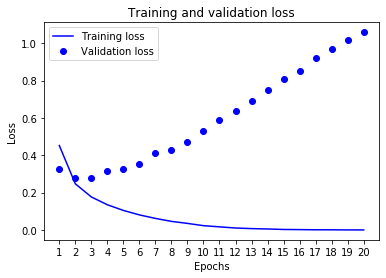

In [19]:

import matplotlib.pyplot as plt
%matplotlib inline

loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss') # 'b'는 파란색 실선을 의미
plt.plot(epochs, val_loss, 'bo', label='Validation loss') # 'bo'는 파란색 점을 의미
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

'''
시작하자마자 overfitting....
epoch 를 3 정도로 놓고 해도 된다.
'''

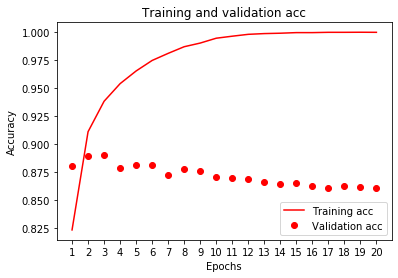

In [20]:
import matplotlib.pyplot as plt


acc, val_acc = history.history['acc'], history.history['val_acc']
epochs = range(1, len(loss)+1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

plt.show()

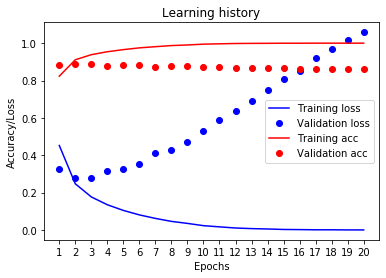

In [21]:
import matplotlib.pyplot as plt

loss, val_loss = history.history['loss'], history.history['val_loss']
acc, val_acc = history.history['acc'], history.history['val_acc']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Learning history')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test loss(20 epochs): ', test_loss)
print('test acc(20 epochs): ', test_acc)

25000/25000 [==============================] - 3s 118us/sample - loss: 1.1472 - acc: 0.8470
test loss(20 epochs):  1.14722578789711
test acc(20 epochs):  0.847


## 7. (과대적합 되기 전까지) 모델 학습

In [23]:
# 기존 model 객체를 사용하면 이어서 학습되므로, 새로운 model 객체를 생성함
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(X_train, 
                    y_train,
                    epochs=3,
                    batch_size=256,
                    validation_data=(X_valid, y_valid))

Train on 15000 samples, validate on 10000 samples
Epoch 1/3
15000/15000 [==============================] - 3s 184us/sample - loss: 0.4469 - acc: 0.8219 - val_loss: 0.3267 - val_acc: 0.8794
Epoch 2/3
15000/15000 [==============================] - 2s 153us/sample - loss: 0.2457 - acc: 0.9155 - val_loss: 0.2736 - val_acc: 0.8939
Epoch 3/3
15000/15000 [==============================] - 2s 156us/sample - loss: 0.1759 - acc: 0.9391 - val_loss: 0.2910 - val_acc: 0.8825


## 8. 학습된 모델로 새로운 데이터 예측

In [24]:
# 여러 개 동시에 예측
result = model.predict(X_test)
print(result)

print()

# 하나씩 개 동시에 예측
sample = X_test[0]
result = model.predict(np.expand_dims(sample, axis=0))
print(result)

[[0.20639041]
 [0.99872524]
 [0.778755  ]
 ...
 [0.05488256]
 [0.05928588]
 [0.27917022]]

[[0.20639041]]
